In [1]:
import pandas as pd
import geopandas as gpd
import maup
from maup import smart_repair
import time
import os
import matplotlib.pyplot as plt
import networkx as nx
from gerrychain import Graph, Partition, proposals, updaters, constraints, accept, MarkovChain, Election
from gerrychain.updaters import cut_edges, Tally
from gerrychain.proposals import recom
from gerrychain.accept import always_accept
from functools import partial
import time
from gerrychain.tree import bipartition_tree

In [2]:
wi_file = gpd.read_file("./WI_DATA/WI.shp") # reads a file from WI_DATA directory
wi_graph = Graph.from_geodataframe(wi_file) # creates a graph from a geodataframe
print(wi_graph.nodes()[0]) # Prints out the attributes of each node in the graph
tot_pop = sum([wi_graph.nodes()[v]['TOTPOP'] for v in wi_graph.nodes()]) # gets the total population for ideal population calculation if the values are numbers
print(tot_pop)

/Users/williamstout/miniconda3/envs/gerry/lib/python3.11/site-packages/gerrychain/graph/graph.py:406: UserWarning: Found islands (degree-0 nodes). Indices of islands: {1220, 5148}
  warnings.warn(


{'boundary_node': False, 'area': 664968.208542657, 'CNTY_FIPS': '55035', 'CNTY_NAME': 'EAU CLAIRE', 'MCD_FIPS': '5503522300', 'MCD_NAME': 'EAU CLAIRE', 'CTV': 'C', 'WARDID': '0060', 'LABEL': 'EAU CLAIRE - C 0060', 'PERSONS': 12, 'RV': 0, 'G20PRED': 0, 'G20PRER': 0, 'TOTPOP': 4.0, 'HISP': 0.0, 'NH_WHITE': 0.0, 'NH_BLACK': 1.0, 'NH_AMIN': 0.0, 'NH_ASIAN': 0.0, 'NH_NHPI': 0.0, 'NH_OTHER': 0.0, 'NH_2MORE': 3.0, 'CD': '3', 'G18USSR': 0.0, 'G18USSD': 0.0, 'G18GOVR': 0.0, 'G18GOVD': 0.0, 'G18ATGR': 0.0, 'G18ATGD': 0.0, 'G18SOSR': 0.0, 'G18SOSD': 0.0, 'G18TRER': 0.0, 'G18TRED': 0.0, 'geometry': <POLYGON ((139292.952 4974890.501, 139269.277 4974487.775, 139622.622 497446...>}
5893718.0


In [3]:
elections = [Election("G20PRE", {"Presidential Democratic": "G20PRED", "Presidential Republican": "G20PRER"}),
             Election("GOV18", {"Governor Democratic": "G18GOVD", "Governor Republican": "G18GOVR"}),
             ]

In [4]:
my_updaters = {
    "our cut edges": cut_edges, # number of cut edges in a graph
    "district population": Tally("TOTPOP", alias = "district population"), # across districts, total population
}
election_updaters = {election.name: election for election in elections}
my_updaters.update(election_updaters)
ct_partition = Partition( # creates a partition for the IL graph
    wi_graph, # dual graph
    assignment = "CD", # initial districting plan
    updaters=my_updaters)
print(ct_partition["district population"]) # Prints the population for each district
ideal_pop = tot_pop/8 # calculates the ideal population 
pop_tolerance = 0.05 # population tolerance for the proposal
print(ideal_pop)

{'3': 736959.0, '2': 736822.0, '6': 736545.0, '4': 736395.0, '1': 736286.0, '8': 736833.0, '7': 736572.0, '5': 737306.0}
736714.75


In [5]:
rw_proposal = partial(recom, ## how you choose a next districting plan
                      pop_col = "TOTPOP", ## What data describes population? 
                      pop_target = ideal_pop, ## What the target/ideal population is for each district 
                                              ## (we calculated ideal pop above)
                      epsilon = pop_tolerance,  ## how far from ideal population you can deviate
                                              ## (we set pop_tolerance above)
                      node_repeats = 100, ## number of times to repeat bipartition.  Can increase if you get a BipartitionWarning
                    #   allow_pair_reselection=True,
                        method = partial(
                        bipartition_tree,
                        max_attempts=100,
                        allow_pair_reselection=True  # <-- This is the only change
    )
                      )
population_constraint = constraints.within_percent_of_ideal_population(
    ct_partition, 
    pop_tolerance, 
    pop_key="district population")

In [6]:
# found this code in gerrychain_intro_complete-2.ipynb
start_time = time.time()
random_walk = MarkovChain( # random walk for 50000 steps
    proposal = rw_proposal, 
    constraints = [population_constraint], # Could add additional constraints here
    accept = always_accept, # Accept every proposed plan that meets the population constraints
    initial_state = ct_partition, 
    total_steps = 50000)

final_df = pd.DataFrame([])

for step, part in enumerate(random_walk):
    if(step != 0 and step % 10000 == 0):
        print("At Step: ", step, "Time: ", (time.time() - start_time)/60)
    final_df.at[step, "Cut Edges"] = len(part["our cut edges"]) ## Cut edge ensemble
    final_df.at[step, "Presidential Democratic Districts"] = part["G20PRE"].seats("Presidential Democratic") ## Democratic Districts ensemble
    final_df.at[step, "Presidential Republican Districts"] = part["G20PRE"].seats("Presidential Republican") ## Republican Districts ensemble
    final_df.at[step, "Presidential Efficiency Gap"] = part["G20PRE"].efficiency_gap() ## Efficiency Gap ensemble
    final_df.at[step, "Governor Democratic Districts"] = part["GOV18"].seats("Governor Democratic") ## Democratic Districts ensemble
    final_df.at[step, "Governor Republican Districts"] = part["GOV18"].seats("Governor Republican") ## Republican Districts ensemble
    final_df.at[step, "Governor Efficiency Gap"] = part["GOV18"].efficiency_gap() ## Efficiency Gap ensemble

end_time = time.time()

print("The time of execution of above program is :",
      (end_time-start_time)/60, "mins")

final_df.to_csv('markov_chain_ensemble_results50000.csv', index=False)

At Step:  10000 Time:  68.33159413337708
At Step:  20000 Time:  134.9994918823242
At Step:  30000 Time:  198.60207911729813
At Step:  40000 Time:  267.51687881946566
The time of execution of above program is : 331.9138542175293 mins


In [9]:
print(final_df["Cut Edges"])
print(final_df["Presidential Democratic Districts"])
print(final_df["Presidential Republican Districts"])
print(final_df["Presidential Efficiency Gap"])
print(final_df["Governor Democratic Districts"])
print(final_df["Governor Republican Districts"])
print(final_df["Governor Efficiency Gap"])

0        672.0
1        704.0
2        684.0
3        690.0
4        709.0
         ...  
49995    651.0
49996    654.0
49997    616.0
49998    650.0
49999    656.0
Name: Cut Edges, Length: 50000, dtype: float64
0        2.0
1        2.0
2        2.0
3        2.0
4        2.0
        ... 
49995    2.0
49996    2.0
49997    2.0
49998    2.0
49999    2.0
Name: Presidential Democratic Districts, Length: 50000, dtype: float64
0        6.0
1        6.0
2        6.0
3        6.0
4        6.0
        ... 
49995    6.0
49996    6.0
49997    6.0
49998    6.0
49999    6.0
Name: Presidential Republican Districts, Length: 50000, dtype: float64
0       -0.267221
1       -0.261475
2       -0.261475
3       -0.261475
4       -0.261475
           ...   
49995   -0.263669
49996   -0.263669
49997   -0.263669
49998   -0.263669
49999   -0.263669
Name: Presidential Efficiency Gap, Length: 50000, dtype: float64
0        3.0
1        3.0
2        3.0
3        3.0
4        3.0
        ... 
49995    2.0
49996 

In [16]:
final_df

,Cut Edges,Presidential Democratic Districts,Presidential Republican Districts,Presidential Efficiency Gap,Governor Democratic Districts,Governor Republican Districts,Governor Efficiency Gap
0,672.0,2.0,6.0,-0.267221,3.0,5.0,-0.140447
1,704.0,2.0,6.0,-0.261475,3.0,5.0,-0.134702
2,684.0,2.0,6.0,-0.261475,3.0,5.0,-0.134702
3,690.0,2.0,6.0,-0.261475,3.0,5.0,-0.134702
4,709.0,2.0,6.0,-0.261475,3.0,5.0,-0.128801
...,...,...,...,...,...,...,...
49995,651.0,2.0,6.0,-0.263669,2.0,6.0,-0.257216
49996,654.0,2.0,6.0,-0.263669,2.0,6.0,-0.257216
49997,616.0,2.0,6.0,-0.263669,2.0,6.0,-0.257216
49998,650.0,2.0,6.0,-0.263669,2.0,6.0,-0.257216


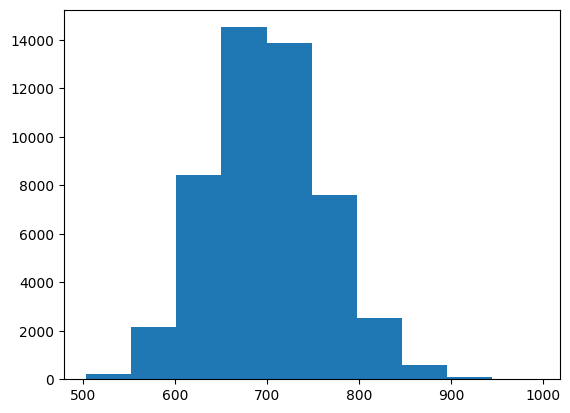

In [10]:
plt.figure()
plt.hist(final_df["Cut Edges"], align = 'left')
plt.show()

In [24]:
import tqdm as notebook_tqdm

pres_dem_values = []
gov_dem_values = []

for step, part in enumerate(random_walk):
    pres_dem_values.append(sorted(part["G20PRE"].percents("Presidential Democratic")))
    gov_dem_values.append(sorted(part["GOV18"].percents("Governor Democratic")))

pres_dem_partition = pd.DataFrame(pres_dem_values)
gov_dem_partition = pd.DataFrame(gov_dem_values)

pres_dem_partition.to_csv('sorted_partition_G20PRE_Democratic_50000.csv', index=True)
gov_dem_partition.to_csv('sorted_partition_GOV18_Democratic_50000.csv', index=True)

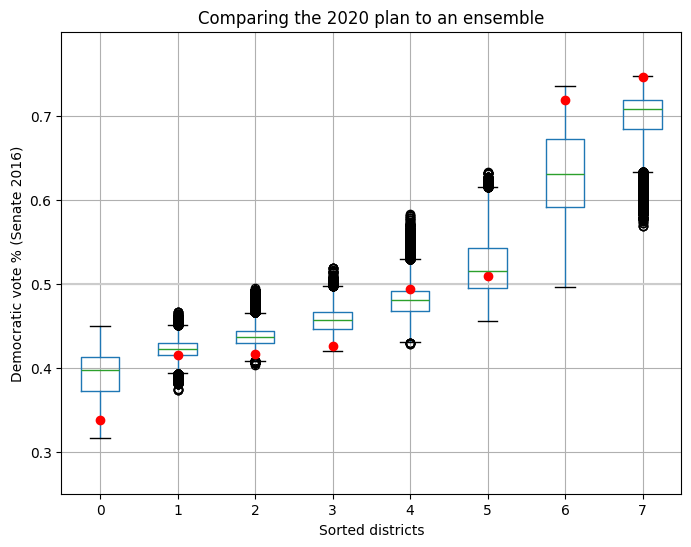

In [27]:
fig, ax = plt.subplots(figsize=(8, 6))

# Draw 50% line
ax.axhline(0.5, color="#cccccc")

# Draw boxplot
gov_dem_partition.boxplot(ax=ax, positions=range(len(gov_dem_partition.columns)))

# Draw initial plan's Democratic vote %s (.iloc[0] gives the first row, which corresponds to the initial plan)
plt.plot(gov_dem_partition.iloc[0], "ro")

# Annotate
ax.set_title("Comparing the 2020 plan to an ensemble")
ax.set_ylabel("Democratic vote % (Senate 2016)")
ax.set_xlabel("Sorted districts")
ax.set_ylim(0.25, 0.8)
ax.set_yticks([0.3, 0.4, 0.5, 0.6, 0.7])
plt.savefig('WI_BoxPlot20162020.png')
plt.show()

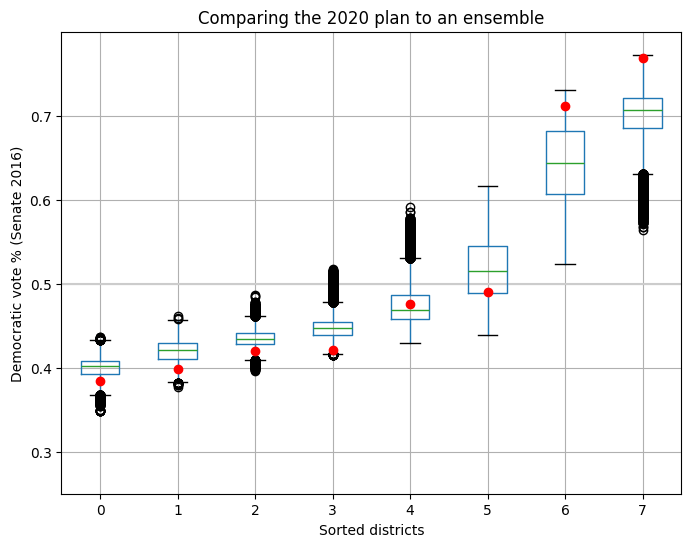

In [28]:
fig, ax = plt.subplots(figsize=(8, 6))

# Draw 50% line
ax.axhline(0.5, color="#cccccc")

# Draw boxplot
pres_dem_partition.boxplot(ax=ax, positions=range(len(pres_dem_partition.columns)))

# Draw initial plan's Democratic vote %s (.iloc[0] gives the first row, which corresponds to the initial plan)
plt.plot(pres_dem_partition.iloc[0], "ro")

# Annotate
ax.set_title("Comparing the 2020 plan to an ensemble")
ax.set_ylabel("Democratic vote % (Senate 2016)")
ax.set_xlabel("Sorted districts")
ax.set_ylim(0.25, 0.8)
ax.set_yticks([0.3, 0.4, 0.5, 0.6, 0.7])
plt.savefig('WI_BoxPlot20162020.png')
plt.show()